In [1]:
# This file is a simulation of a simple single phase (single phase, not 3 phase balanced) network with inverter
'''
This file is a simulation of a simple single phase (single phase, not 3 phase balanced) network,
with inverters providing reactive power compensation. The inverters can be attacked, with the attacker
altering the Volt-VAr curve to create oscillations.
'''

'\nThis file is a simulation of a simple single phase (single phase, not 3 phase balanced) network,\nwith inverters providing reactive power compensation. The inverters can be attacked, with the attacker\naltering the Volt-VAr curve to create oscillations.\n'

In [2]:
# Import necessary packages

import numpy as np
import opendssdirect as dss
# from utils.device.Inverter import Inverter
# from utils.controller.AdaptiveInvController import AdaptiveInvController
# from utils.controller.FixedInvController import FixedInvController
import matplotlib.pyplot as plt
from math import tan,acos
import copy
import pandas as pd
import time

%matplotlib inline

# import numpy as np
# from matplotlib.mlab import PCA
# from sklearn.decomposition import PCA

import scipy.linalg as spla

In [3]:
# Set global variables and parameters, and test OpenDSS with network


#######################################################
###Global variable initialization and error checking###
#######################################################

Sbase=1
LoadScalingFactor = 3
GenerationScalingFactor = 5
SlackBusVoltage = 1.00
NoiseMultiplyer= 1
#Set simulation analysis period - the simulation is from StartTime to EndTime
StartTime = 40600
EndTime = StartTime + 640
EndTime += 1 # creating a list, last element does not count, so we increase EndTime by 1
#Set hack parameters
TimeStepOfHack = 160
PercentHacked = np.array([0,0,0,0,0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0,0,0,0,0,0,0,0,0,0,0,0,0])

#Set initial VBP parameters for uncompromised inverters
VBP_normal=np.array([0.97, 1, 1, 1.03, 1.06])
VBP_attack=np.array([0.997, 1, 1, 1.003, 1.007])

#Set delays for each node
Delay_VBPCurveShift = (30+2*np.random.randn(31)).astype(int)
#Delay_VBPCurveShift = (10+2*np.random.randn(31)).astype(int)
lpf_meas_vector = (1+0.2*np.random.randn(31))
lpf_output_vector= (0.1+0.015*np.random.randn(31))

#Set observer voltage threshold
ThreshHold_vqvp = 0.06
adaptive_gain=800


power_factor=0.9
pf_converted=tan(acos(power_factor))
# Number_of_Inverters = 13 #even feeder is 34Bus, we only have 13 inverters


#Error checking of the global variable -- TODO: add error handling here!
if EndTime < StartTime or EndTime < 0 or StartTime < 0:
    print('Setup Simulation Times Inappropriately.')
if NoiseMultiplyer < 0:
    print('Setup Noise Multiplyer Correctly.')

# Select OpenDSS file
dss.run_command('Redirect 05node_singlephase_balanced_oscillation.dss')

# Solve power flow with OpenDSS file
dss.Solution.Solve()
if not dss.Solution.Converged:
    print('Initial Solution Not Converged. Check Model for Convergence')
else:
    print('Initial Model Converged. Proceeding to Next Step.')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

print('')

# Print number of buses, and bus names
print(len(dss.Circuit.AllBusNames()))
print(dss.Circuit.AllBusNames())

# Print number of loads, and load names
print(len(dss.Loads.AllNames()))
print(dss.Loads.AllNames())

print('')

# Print different voltage measurements
for k1 in range(len(dss.Circuit.AllBusNames())):
    if dss.Circuit.AllBusNames()[k1] == 'sourcebus':
        dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
        
        print(dss.Circuit.AllBusNames()[k1])
        print('BASE - LN')
        print(dss.Bus.kVBase())
        print('VMAGANGLE - LN POLAR')
        print(dss.Bus.VMagAngle())
        print('puVMAGANGLE - LN POLAR')
        print(dss.Bus.puVmagAngle())
        print('VOTLAGES - LN CARTESIAN')
        print(dss.Bus.Voltages())
        print('puVOTLAGES - LN CARTESIAN')
        print(dss.Bus.PuVoltage())
        print('VLL - LL CARTESIAN')
        print(dss.Bus.VLL())
        print('puVLL - LL CARTESIAN')
        print(dss.Bus.puVLL())
        
        tempvoltage = dss.Bus.Voltages()
        
        Vab = tempvoltage[0]
        
print('')
        
for k1 in range(len(dss.Circuit.AllBusNames())):
    dss.Circuit.SetActiveBus(dss.Circuit.AllBusNames()[k1])
    print(dss.Circuit.AllBusNames()[k1])
    print('BASE - LN')
    print(dss.Bus.kVBase())
    print('VMAGANGLE - LN POLAR')
    print(dss.Bus.VMagAngle())
    print('puVMAGANGLE - LN POLAR')
    print(dss.Bus.puVmagAngle())
    print('')

    
# dir(dss.Bus)

Initial Model Converged. Proceeding to Next Step.
OpenDSS Model Compliation Done.

7
['sourcebus', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06']
16
['load_a02_a', 'load_a04_a', 'load_a05_a', 'load_a06_a', 'inv_a01_a', 'inv_a02_a', 'inv_a03_a', 'inv_a04_a', 'inv_a05_a', 'inv_a06_a', 'esc_a01_a', 'esc_a02_a', 'esc_a03_a', 'esc_a04_a', 'esc_a05_a', 'esc_a06_a']

sourcebus
BASE - LN
132.79056191361394
VMAGANGLE - LN POLAR
[132790.14928767522, -0.00023915834085314823, 132790.52584383823, -120.00000542994597, 132790.59088387463, 119.99998924740241]
puVMAGANGLE - LN POLAR
[0.9999968926561288, -0.00023915834085314823, 0.9999997283709385, -120.00000542994597, 1.0000002181650585, 119.99998924740241]
VOTLAGES - LN CARTESIAN
[132790.1492865184, -0.5542794261075941, -66395.27383344938, -114999.96246288231, -66395.2738730183, 115000.03754180021]
puVOTLAGES - LN CARTESIAN
[0.9999968926474172, -4.174087511341183e-06, -0.4999999463564467, -0.8660251211053299, -0.49999994665442665, 0.8660256864988098]
VLL -

In [4]:
# Inverter object class


class inverter():
    
    def __init__(self):
        
        #
        self.max_reactive_capacity = 1
        self.reactive_capacity = 1
    
        # Current reactive power
        self.reactive_power = 0
    
        # Volt-VAr curve breakpoints
        self.VBP = np.array([0.97, 0.99, 1.01, 1.03])
        
        # Lowpass filter cutoff frequency
        self.wlp = 2*np.pi*1.0
        
        # Lowpass filter timestep
        self.Ts = 0.01
        
        # Measured voltage
        self.Vmeas = np.zeros(86401)
        
        # Lowpass filter voltage
        self.Vlp = np.zeros(86401)
        
        # Array of reactive power
        self.reactive_power = np.zeros(86401)
        
        # attack status
        self.hackFlag = False
        
    def set_timesteps(self, startTimeStep, endTimeStep):
        self.startTimeStep = startTimeStep
        self.endTimeStep = endTimeStep
        
        self.Vmeas = np.zeros(endTimeStep - startTimeStep)
        self.Vlp = np.zeros(endTimeStep - startTimeStep)
        self.reactive_power = np.zeros(endTimeStep - startTimeStep)
        
    # set the index of the node where the inverter is located
    def set_nodenum(self, nodenum):
        self.nodenum = nodenum
        
    # set the name of the node where the inverter is located
    def set_nodename(self, nodename):
        self.nodename = nodename
        
    # set the name of the node where the inverter is located
    def set_loadname(self, loadname):
        self.loadname = loadname
        
    def set_VAr_capacity(self, VAr_capacity):
        self.VAr_capacity = VAr_capacity
    
    # set Volt-VAr curve breakpoints
    def set_VBP(self, VBP):
        self.VBP = VBP
    
    # set measured voltage
    def measure_voltage(self, timeStep, Vmeas):
        self.Vmeas[kt] = Vmeas
    
    # lowpass filter voltage measurements
    def lowpass(self, kt):
        self.Vlp[kt] = (1 - self.wlp*self.Ts)*self.Vlp[kt-1] + self.wlp*self.Ts*self.Vmeas[kt-1]
    
    # compute reactive power from lowpass filtered voltage and Volt-Var curve
    def compute_reactive_power_output(self, kt, Vcomp):
        if Vcomp <= self.VBP[0]:
            self.reactive_power[kt] = -100
        elif self.VBP[0] <= Vcomp <= self.VBP[1]:
            self.reactive_power[kt] =100/(self.VBP[1] - self.VBP[0])*(Vcomp - self.VBP[1])
        elif self.VBP[1] <= Vcomp <= self.VBP[2]:
            self.reactive_power[kt] = 0
        elif self.VBP[2] <= Vcomp <= self.VBP[3]:
            self.reactive_power[kt] = 100/(self.VBP[3] - self.VBP[2])*(Vcomp - self.VBP[2])
        elif self.VBP[3] <= Vcomp:
            self.reactive_power[kt] = 100
        # print(self.reactive_power)
        
    

x1 = inverter()
x1.set_VBP(np.array([0.97, 0.99, 1.01, 1.03]))
print(x1.VBP)

x1.compute_reactive_power_output(0,1.02)
print(x1.reactive_power)

print(x1.Vmeas)
print(x1.Vlp)

[0.97 0.99 1.01 1.03]
[50.  0.  0. ...  0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [5]:
# Run simulation

dss.run_command('Redirect 05node_singlephase_balanced_oscillation.dss')
dss.Solution.Solve()


if dss.Solution.Converged:
    print('Initial Model Converged. Proceeding to Next Step.')
    
else:
    print('Initial Solution Not Converged. Check Model for Convergence')
    #Doing this solve command is required for GridPV, that is why the monitors
    #go under a reset process
    dss.Monitors.ResetAll()
    
    #set solution Params
    #setSolutionParams(dss,'daily',1,1,'off',1000000,30000)
    dss.Solution.Mode(1)
    dss.Solution.Number(1)
    dss.Solution.StepSize(1)
    dss.Solution.ControlMode(-1)
    dss.Solution.MaxControlIterations(1000000)
    dss.Solution.MaxIterations(30000)
    #Easy process to get all names and count of loads, a trick to avoid
    #some more lines of code
    TotalLoads=dss.Loads.Count()
    AllLoadNames=dss.Loads.AllNames()
    print('OpenDSS Model Compliation Done.')

    

# Set slack bus (sourcebus) voltage reference in p.u. 
dss.Vsources.PU(SlackBusVoltage)

############################################
############ INIT NODES ####################
############################################
""" 
 nodes' variable is a dictionary contains all the nodes in the grid,
 with KEY is the node's number, VALUE is a dataframe with 
 ROW is ['Voltage', 'Generation', 'P', 'Q'] - Voltage is Voltage for each timestep; 
                                              P,Q is P,Q injection at that node for that timestep.
 and 
 COLUMN is each timestep for the whole simulation. 
 nodes = {
    1: dataFrame1,
    2: dataFrame2
 }
"""

nodes = {}
features = ['Voltage', 'Generation', 'P', 'Q']

# for k1 in range(len(AllLoadNames)):
#     print(k1)
#     df = pd.DataFrame(columns=list(range(len(time))),index=features)
#     nodes[k1] = df
#     nodes[k1].loc['Generation'] = Generation[:,k1]
#     nodes[k1].loc['Load'] = Load[:,k1]
#     nodes[k1].loc['P'] = 0
#     nodes[k1].loc['Q'] = 0
#     nodes[k1].loc['Pinj'] = 0
#     nodes[k1].loc['Qinj'] = 0
    

    
################################################
############ INIT INVERTERS ####################
################################################
""" 
 inverters' variable is a dictionary contains all the inverters in the grid,
 with KEY is the node's number where we have inverters, VALUE is a list of inverters at that node.
 
 Each inverter has a dictionary:
     'device': Inverter_Object
     'controller: Controller_Object
     'info': contain scenario information in a dataframe (solar generation, sbar) for each timestep at that node
 }
"""

# time array
time = np.arange(0,600,0.01)

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),len(AllBuses)))

# All loads and load voltages
LoadBuses = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((len(time),len(LoadBuses)))



##################################################
# Set up inverters
##################################################

# Create inverters and assign to existing load buses
# inverters = []
# for k1 in range(len(LoadBuses)):
#     if LoadBuses[k1] == 's701a' or LoadBuses[k1] == 's702a':
# #         for k2 in range(generation_indexes.shape[1]):
#         for k2 in range(0,1):

#     #         inverters[k1] = []
#             tempinverter = inverter()
#             tempinverter.set_timesteps(0,len(time))
#             tempinverter.set_nodenum(k1)
#             tempinverter.set_nodename(LoadBuses[k1])
#             tempinverter.set_VBP(np.array([0.95, 0.97, 1.03, 1.05]))
#             tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

#             inverters.append(tempinverter)
            
invbuslist = ['a03','a05']
            
inverters = []
for k1 in range(len(invbuslist)):
    tempinverter = inverter()
    tempinverter.set_timesteps(0,len(time))
#     tempinverter.set_nodenum(k1)
    tempinverter.set_nodename(invbuslist[k1])
    tempinverter.set_loadname('inv_' + invbuslist[k1] + '_a')
    tempinverter.set_VBP(np.array([0.95, 0.99, 1.01, 1.05]))

    inverters.append(tempinverter)

    
##################################################
# ?
##################################################

# All buses and bus voltages
AllBuses = dss.Circuit.AllBusNames()
AllBusVoltage = np.zeros((len(time),len(AllBuses)))

# All loads and load voltages
LoadBuses = dss.Loads.AllNames()
LoadBusVoltage = np.zeros((len(time),len(LoadBuses)))

#
LoadBusPinj = np.zeros((len(time),len(LoadBuses))) 
LoadBusQinj = np.zeros((len(time),len(LoadBuses)))

kWloadTS = np.zeros((len(time),len(LoadBuses)))
kVArloadTS = np.zeros((len(time),len(LoadBuses)))

kWtotalTS = np.zeros((len(time),len(LoadBuses)))
kVArtotalTS = np.zeros((len(time),len(LoadBuses)))

# Real power load, injection, total for load buses
PloadTS = np.zeros((len(time),len(LoadBuses)))
PinvTS = np.zeros((len(time),len(LoadBuses)))
PescTS = np.zeros((len(time),len(LoadBuses)))
PtotalTS = np.zeros((len(time),len(LoadBuses)))

# Reactive power load, injection, total for load buses
QloadTS = np.zeros((len(time),len(LoadBuses)))
QinvTS = np.zeros((len(time),len(LoadBuses)))
QescTS = np.zeros((len(time),len(LoadBuses)))
QtotalTS = np.zeros((len(time),len(LoadBuses)))

# Nominal real and reactive power loads in kW and kVAr, from OpenDSS file
PloadNominal = np.zeros(len(LoadBuses))
QloadNominal = np.zeros(len(LoadBuses))
# Array of frequencies for load modulation
lf = np.zeros(len(LoadBuses))
for k1 in range(len(LoadBuses)):
    dss.Loads.Name(LoadBuses[k1])
    PloadNominal[k1] = dss.Loads.kW()
    QloadNominal[k1] = dss.Loads.kvar()
    lf[k1] = 1 + 0.2*(np.random.rand()-0.5)
    
print(LoadBuses)
print(PloadNominal)
print(QloadNominal)
print(lf)
print('')

# iterate through timesteps
for kt in range(0,len(time)):
       
    # print when each minute has elapsed
    if time[kt] % 60 == 0:
        hh = int((time[kt]-1)/3600)
        mm = int(((time[kt]-1) - 3600*int((time[kt]-1)/3600))/60)
        if mm <= 9:
            print(str(hh) + '.0' + str(mm))
        else:
            print(str(hh) + '.' + str(mm))
    
    # At first time step, initialize loads, with no control
    if kt == 0:
        for k1 in range(len(LoadBuses)):
            
            if 'load' in LoadBuses[k1]:
                dss.Loads.Name(LoadBuses[k1])
                
                PloadTS[kt,k1] = PloadNominal[k1]
                dss.Loads.kW(PloadTS[kt,k1])
                
                QloadTS[kt,k1] = QloadNominal[k1]
                dss.Loads.kvar(QloadTS[kt,k1])
                
#             if 'inv' in LoadBuses[k1]:
#                 dss.Loads.Name(LoadBuses[k1])                
                
#                 PinvTS[kt,k1] = 0
#                 dss.Loads.kW(PinvTS[kt,k1])
                
#                 QinvTS[kt,k1] = 0
#                 dss.Loads.kvar(QinvTS[kt,k1])
                
#             if 'esc' in LoadBuses[k1]:
#                 dss.Loads.Name(LoadBuses[k1])
                
#                 PescTS[kt,k1] = 0
#                 dss.Loads.kW(PescTS[kt,k1])
                
#                 QescTS[kt,k1] = 0
#                 dss.Loads.kvar(QescTS[kt,k1])

    # Compute total loading
    else:
        for k1 in range(len(LoadBuses)):
            
            if 'load' in LoadBuses[k1]:
                dss.Loads.Name(LoadBuses[k1])
                
                PloadTS[kt,k1] = PloadNominal[k1] + 25*np.sin(2*np.pi*lf[k1]*1/60*kt)
                dss.Loads.kW(PloadTS[kt,k1])
                
                QloadTS[kt,k1] = QloadNominal[k1] + 15*np.sin(2*np.pi*lf[k1]*1/60*kt)
                dss.Loads.kvar(QloadTS[kt,k1])
                
            for k1 in range(len(inverters)):            
                dss.Loads.Name(inverters[k1].loadname)

                PinvTS[kt,k1] = 0
                dss.Loads.kW(PinvTS[kt,k1])

                QinvTS[kt,k1] = 1/100*1000*inverters[k1].reactive_power[kt-1]
                dss.Loads.kvar(QinvTS[kt,k1])
                
#             if 'inv' in LoadBuses[k1]:
#                 dss.Loads.Name(LoadBuses[k1])                
                
#                 PinvTS[kt,k1] = 0
#                 dss.Loads.kW(PinvTS[kt,k1])
                
#                 QinvTS[kt,k1] = 0
#                 dss.Loads.kvar(QinvTS[kt,k1])
                
#             if 'esc' in LoadBuses[k1]:
#                 dss.Loads.Name(LoadBuses[k1])
                
#                 PescTS[kt,k1] = 0
#                 dss.Loads.kW(PescTS[kt,k1])
                
#                 QescTS[kt,k1] = 0
#                 dss.Loads.kvar(QescTS[kt,k1])

    # solve power flow with OpenDSS file and newly assigned loads
    dss.Solution.Solve()
    if not dss.Solution.Converged:
        print('Solution Not Converged at Step:', kt)
        
    dss.Monitors.SampleAll()
    #get the voltage info
    #(voltage[0]+voltage[2]+voltage[4])/(DSSCircuit.ActiveElement.NumPhases*(Loads.kV*1000/(3**0.5)))
    nodeInfo = []
    
    for k1 in range(len(LoadBuses)):
        dss.Loads.Name(LoadBuses[k1])
        voltage = dss.CktElement.VoltagesMagAng()
#         print(dss.CktElement.NodeOrder())
#         print(voltage)
#         voltagePU = (voltage[0]+voltage[2]+voltage[4])/(dss.CktElement.NumPhases()*(dss.Loads.kV()*1000/(3**0.5)))

#         LoadBusVoltage[kt,k1] = voltagePU
        
#     for k1 in range(len(AllBuses)):
# #         dss.Loads.Name(LoadBuses[k1])
#         dss.Circuit.SetActiveBus(AllBuses[k1])
#         tempVoltagePU = dss.Bus.puVmagAngle()
# #         print(tempVoltagePU)
# #         print(tempVoltage)
# #         print(tempVoltage[::2])
#         tempVoltagePU = tempVoltagePU[::2]
#         tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
# #         print(tempVoltage)
#         LoadBusVoltage[kt,k1] = tempVoltagePU
    
    # Iterate through all buses, store voltage
    for k1 in range(len(AllBuses)):
        dss.Circuit.SetActiveBus(AllBuses[k1])
        tempVoltagePU = dss.Bus.puVmagAngle()[::2]
#         print(AllBuses[k1])
#         print(tempVoltage)
        tempVoltagePU = np.sum(tempVoltagePU)/len(tempVoltagePU)
#         tempVoltagePU = tempVoltage/(dss.Bus.kVBase()*1000)        
        AllBusVoltage[kt,k1] = tempVoltagePU
        
#         print(dss.Bus.VMagAngle())
        
#         if kt == simStartTimeStep + 20:
#             print(AllBuses[k1], tempVoltagePU)
        
#     for k1 in range(len(LoadBuses)):
        
#         inverters[k1].measure_voltage(kt,LoadBusVoltage[kt,k1])
#         inverters[k1].lowpass(kt)
    
#     # Iterate through inverters
    for k1 in range(len(inverters)):
        
        AllBuses.index(inverters[k1].nodename)
        
        inverters[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverters[k1].nodename)])
        
        inverters[k1].lowpass(kt)
        
        if kt >= 10:            
            inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
#         # Get index of bus at which inverter is located - fix this
#         AllBuses.index(inverters[k1].nodename[1:4])
        
#         # inverter takes local voltage measurement
#         inverters[k1].measure_voltage(kt,AllBusVoltage[kt,AllBuses.index(inverters[k1].nodename[1:4])])
#         # inverter lowpass filters voltage
#         inverters[k1].lowpass(kt)
        
#         # set reactive power setpoint to 0 for first 10 time steps (to allow lowpass filter to ramp up)
#         if kt >= simStartTimeStep + 10:            
#             inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])
        
# #         inverters[k1].compute_reactive_power_output(kt, inverters[k1].Vlp[kt])


    # Attack inverters at this timestep
    if kt == 120*100+1:
        for k1 in range(len(inverters)):
            # Set new Volt-VAr curve breakpoints
            inverters[k1].set_VBP(inverters[k1].VBP)
            if np.random.rand() <= 2:
                inverters[k1].hackFlag = True
                inverters[k1].set_VBP(np.array([0.995, 0.999, 1.001, 1.005]))
                print('~~~~~')
                print(kt)
                print(inverters[k1].nodename)


                

Initial Model Converged. Proceeding to Next Step.
['load_a02_a', 'load_a04_a', 'load_a05_a', 'load_a06_a', 'inv_a01_a', 'inv_a02_a', 'inv_a03_a', 'inv_a04_a', 'inv_a05_a', 'inv_a06_a', 'esc_a01_a', 'esc_a02_a', 'esc_a03_a', 'esc_a04_a', 'esc_a05_a', 'esc_a06_a']
[140. 300. 300. 300.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[ 70. 100. 100. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
[1.027815   0.96456478 0.94367116 1.03953847 1.00645158 1.07911571
 1.01364941 1.07484981 0.9834256  1.03717555 0.92617774 0.96863956
 1.09861707 0.92591452 0.91706661 0.92600344]

0.00
0.00
0.01
~~~~~
12001
a03
~~~~~
12001
a05
0.02
0.03
0.04
0.05
0.06
0.07
0.08


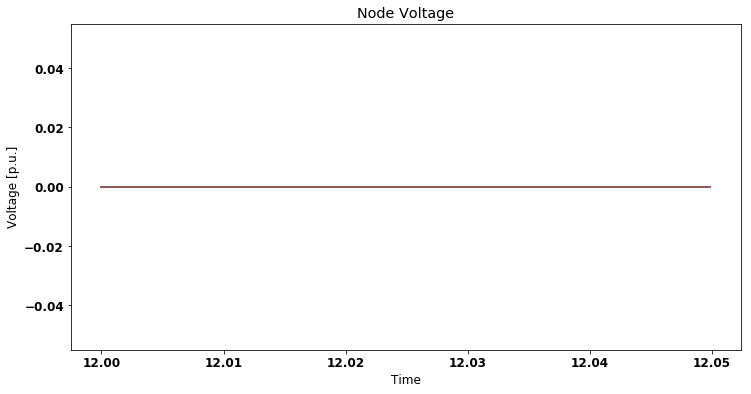

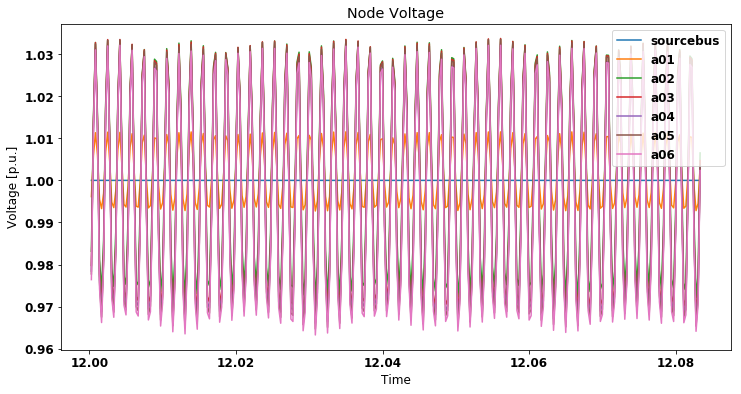

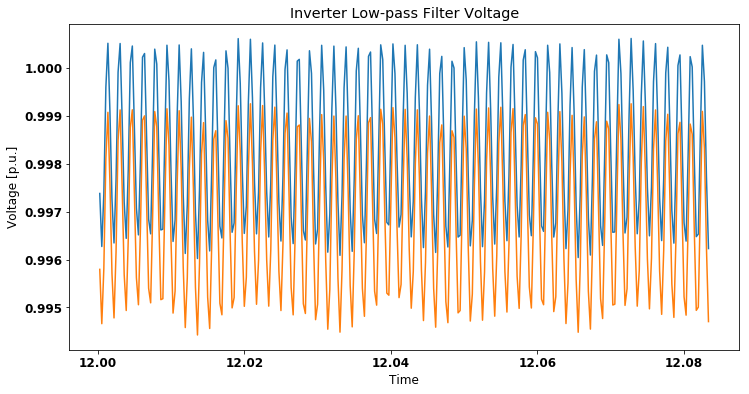

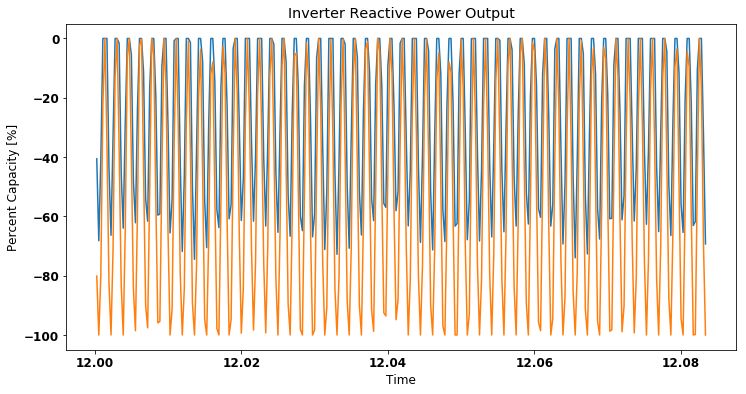

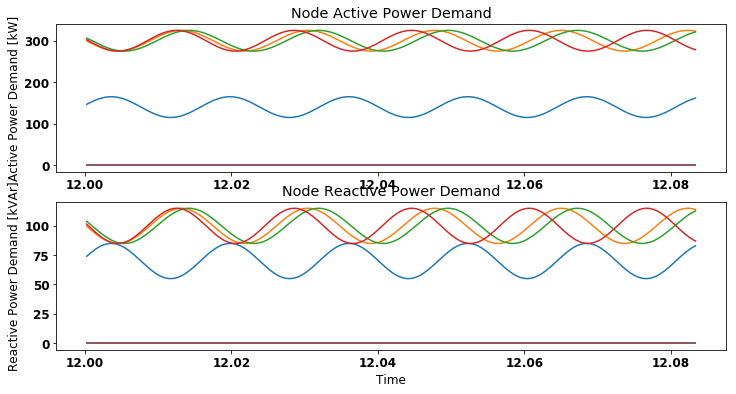

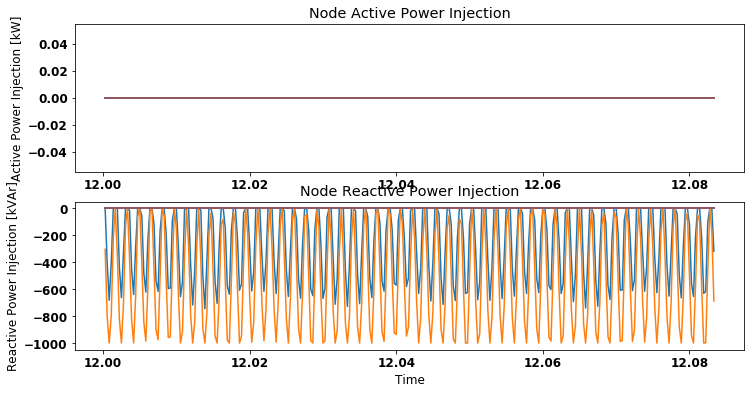

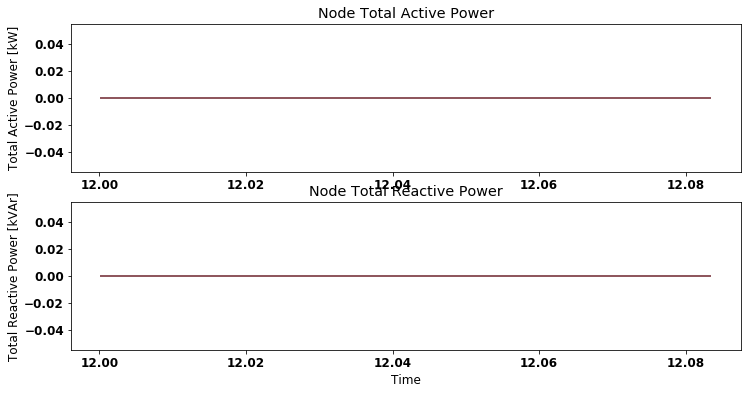

In [6]:
font = {'weight':'bold', 'size':12}

plt.rc('font', **font)

plotStartTimeStep = 12*3600 + 1
plotEndTimeStep = 12*3600 + 1 + 300

time = np.arange(plotStartTimeStep,plotEndTimeStep)

timehh = ((time-1)/3600).astype(int)
timemm = ((time-1) - 3600*timehh)/60

timeplot = timehh.astype(float) + timemm/100

fig = plt.figure(figsize=[12,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(LoadBuses)):
#     plt.plot(time/3600,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1])
    plt.plot(timeplot,LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1] - np.mean(LoadBusVoltage[plotStartTimeStep:plotEndTimeStep,k1]))
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()


fig = plt.figure(figsize=[12,6])
# for k1 in range(0,LoadBusVoltage.shape[1]):
for k1 in range(len(AllBuses)):
    plt.plot(time/3600,AllBusVoltage[plotStartTimeStep:plotEndTimeStep,k1],label=AllBuses[k1])
#     print(LoadBuses[k1])
plt.title('Node Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.legend()
plt.show()

fig = plt.figure(figsize=[12,6])
for k1 in range(0,len(inverters)):
#     plt.plot(inverters[k1].Vmeas[plotStartTimeStep:plotEndTimeStep])
    plt.plot(time/3600,inverters[k1].Vlp[plotStartTimeStep:plotEndTimeStep])
# plt.ylim([0.85, 1.05])
plt.title('Inverter Low-pass Filter Voltage')
plt.xlabel('Time')
plt.ylabel('Voltage [p.u.]')
plt.show()

fig = plt.figure(figsize=[12,6])
for k1 in range(0,len(inverters)):
    plt.plot(time/3600,inverters[k1].reactive_power[plotStartTimeStep:plotEndTimeStep])
# plt.ylim([-100, 100])
plt.title('Inverter Reactive Power Output')
plt.xlabel('Time')
plt.ylabel('Percent Capacity [%]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Load Demands')
# plt.xlabel('Time')
# plt.ylabel('Percent Capacity [%]')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PloadTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Active Power Demand')
# plt.xlabel('Time')
plt.ylabel('Active Power Demand [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QloadTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Reactive Power Demand')
plt.xlabel('Time')
plt.ylabel('Reactive Power Demand [kVAr]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QinjTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Injection')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PinvTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Active Power Injection')
# plt.xlabel('Time')
plt.ylabel('Active Power Injection [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QinvTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Reactive Power Injection')
plt.xlabel('Time')
plt.ylabel('Reactive Power Injection [kVAr]')
plt.show()

# fig = plt.figure(figsize=[12,6])
# plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
# plt.title('Total')
# plt.show()

fig = plt.figure(figsize=[12,6])
plt.subplot(2,1,1)
plt.plot(time/3600,PtotalTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Total Active Power')
# plt.xlabel('Time')
plt.ylabel('Total Active Power [kW]')
plt.subplot(2,1,2)
plt.plot(time/3600,QtotalTS[plotStartTimeStep:plotEndTimeStep,:])
plt.title('Node Total Reactive Power')
plt.xlabel('Time')
plt.ylabel('Total Reactive Power [kVAr]')
plt.show()

# print(timeplot)


In [7]:
AllBuses

['sourcebus', 'a01', 'a02', 'a03', 'a04', 'a05', 'a06']

In [8]:
AllBuses.index(inverters[k1].nodename)
AllBuses[AllBuses.index(inverters[k1].nodename)]

'a05'